In [250]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [251]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0700.hk')
# data.drop("Adj Close",axis=1,inplace=True)
data.head(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-16,0.875,0.925,0.815,0.830,0.802119,2198875000
2004-06-17,0.830,0.875,0.825,0.845,0.816615,419007500
2004-06-18,0.840,0.850,0.790,0.805,0.777959,182990000
2004-06-21,0.820,0.825,0.790,0.800,0.773127,114085000
2004-06-22,0.800,0.800,0.800,0.800,0.773127,0
2004-06-23,0.810,0.890,0.805,0.885,0.855272,275080000
2004-06-24,0.895,0.905,0.865,0.890,0.860104,173615000
2004-06-25,0.895,0.910,0.870,0.880,0.850439,106062500
2004-06-28,0.880,0.880,0.850,0.865,0.835943,73730000


In [252]:
scaler=MinMaxScaler(feature_range=(-1,1))
df = data
#Create one more column Prediction shifted 15 days up. 
df['Prediction'] = data[['Close']].shift(-1)
#print data set
df=df.dropna()
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-06-16    0.875000    0.925000    0.815000    0.830000    0.802119   
2004-06-17    0.830000    0.875000    0.825000    0.845000    0.816615   
2004-06-18    0.840000    0.850000    0.790000    0.805000    0.777959   
2004-06-21    0.820000    0.825000    0.790000    0.800000    0.773127   
2004-06-22    0.800000    0.800000    0.800000    0.800000    0.773127   
...                ...         ...         ...         ...         ...   
2021-12-24  460.799988  460.799988  460.799988  460.799988  460.799988   
2021-12-28  457.799988  459.200012  445.000000  450.399994  450.399994   
2021-12-29  443.600006  445.600006  440.399994  444.799988  444.799988   
2021-12-30  446.399994  450.799988  442.000000  443.399994  443.399994   
2021-12-31  458.000000  458.000000  458.000000  458.000000  458.000000   

                Volume  Prediction  


In [253]:
#Create a data set X and convert it into numpy array , which will be having actual values
X = np.array(df.drop(['Prediction'],1))
# X=scaler.fit_transform(X)
#Remove the last 100 rows
x_unseen=X[-100:]
X=X[:-100]
print(X.shape)
# Create a dataset y which will be having Predicted values and convert into numpy array
scaler_y=MinMaxScaler(feature_range=(-1,1))
y = np.array(df['Prediction']).reshape(-1,1)
# y=scaler_y.fit_transform(y)
# Remove Last 100 rows
y_unseen=y[-100:]
y=y[:-100]
print(y.shape)

(4239, 6)
(4239, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_89657/2633721705.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df.drop(['Prediction'],1))


In [254]:
# Split the data into train and test with 90 & 10 % respectively
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

In [255]:
# SVM Model
svr = make_pipeline(MinMaxScaler(feature_range=(-1,1)),SVR())
# Train the model 
svr.fit(x_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('minmaxscaler', MinMaxScaler(feature_range=(-1, 1))),
                ('svr', SVR())])

In [256]:
# The best possible score is 1.0
svm_confidence = svr.score(x_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  -6.483729580422853


In [257]:
y_pred=svr.predict(x_test).reshape(-1,1)
# y_pred=scaler_y.inverse_transform(y_pred)
# y_test=scaler_y.inverse_transform(y_test)

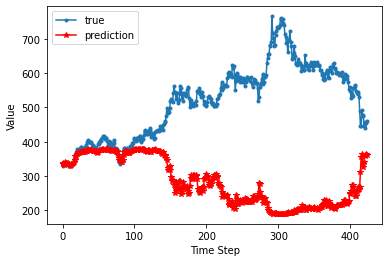

In [258]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [259]:
mean_squared_error(y_test,y_pred,squared=False)

291.9684448191071

In [260]:
mean_absolute_percentage_error(y_test,y_pred)

0.4012394071686487

In [261]:
r2_score(y_test,y_pred)

-6.483729580422853

# Unseen Data

In [262]:
svm_prediction = svr.predict(x_unseen)
# svm_prediction=scaler_y.inverse_transform(svm_prediction.reshape(-1,1))
# y_unseen=scaler_y.inverse_transform(y_unseen.reshape(-1,1))

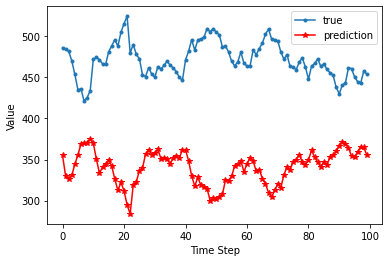

In [263]:
plt.plot(y_unseen, marker='.', label="true")
plt.plot(svm_prediction, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [264]:
r2_score(y_unseen,svm_prediction)

-41.00248850115192

In [265]:
mean_squared_error(y_unseen,svm_prediction,squared=False)

136.5188513646275

In [266]:
mean_absolute_percentage_error(y_unseen,svm_prediction)

0.2743920571816627